In [1]:
import glob
import pandas as pd
from collections import defaultdict
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

/Users/themistoklis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/themistoklis/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Lets list all the files that we have.

In [137]:
directory = '/Users/themistoklis/Desktop/BU/Animal Reports/Analyze Boston/'

# Use glob to find all .csv files in the directory
csv_files = glob.glob(directory + '/*.csv')
csv_files = sorted(csv_files)

for file in csv_files:
    print(file)

Datasets/Analyze Boston/Boston_311_service_request_2011.csv
Datasets/Analyze Boston/Boston_311_service_request_2012.csv
Datasets/Analyze Boston/Boston_311_service_request_2013.csv
Datasets/Analyze Boston/Boston_311_service_request_2014.csv
Datasets/Analyze Boston/Boston_311_service_request_2015.csv
Datasets/Analyze Boston/Boston_311_service_request_2016.csv
Datasets/Analyze Boston/Boston_311_service_request_2017.csv
Datasets/Analyze Boston/Boston_311_service_request_2018.csv
Datasets/Analyze Boston/Boston_311_service_request_2019.csv
Datasets/Analyze Boston/Boston_311_service_request_2020.csv
Datasets/Analyze Boston/Boston_311_service_request_2021.csv
Datasets/Analyze Boston/Boston_311_service_request_2022.csv
Datasets/Analyze Boston/Boston_311_service_request_2023.csv
Datasets/Analyze Boston/Boston_311_service_request_2024.csv


In order to extract the animal related requests, we seek out the word "animal" in the case_title column. Most titles are selfevident and this field is entered by call takers on a call-by-call basis. However, some requests lack information in this column, so we will remove them from our dataset (at least for now).

In [138]:
df = pd.DataFrame()
requests = defaultdict(lambda: {'all': 0, 'animal': 0})

#iterate over the csv files and read them as tmp_df
for file in csv_files:
    print(file)
    tmp_df = pd.read_csv(file, low_memory=False)
    num_requests = len(tmp_df)
    # print number of rows dropped
    print('Number of NaN rows to be dropped: ', len(tmp_df) - len(tmp_df.dropna(subset=['case_title'])))
    #drop rows with nan in case_title
    tmp_df = tmp_df.dropna(subset=['case_title'])
    #keep rows that have "animal" in the "case_title" column
    tmp_df = tmp_df[tmp_df['case_title'].str.contains('animal', case=False)]
    year = file.split('_')[-1].split('.')[0]
    #create a new column called "year" and set it to the year
    tmp_df['year'] = year
    requests[year]['all'] = num_requests
    requests[year]['animal'] = len(tmp_df)

    #concatenate the tmp_df to df
    df = pd.concat([df, tmp_df], ignore_index=True)

Datasets/Analyze Boston/Boston_311_service_request_2011.csv
Number of NaN rows to be dropped:  0
Datasets/Analyze Boston/Boston_311_service_request_2012.csv
Number of NaN rows to be dropped:  0
Datasets/Analyze Boston/Boston_311_service_request_2013.csv
Number of NaN rows to be dropped:  4
Datasets/Analyze Boston/Boston_311_service_request_2014.csv
Number of NaN rows to be dropped:  175
Datasets/Analyze Boston/Boston_311_service_request_2015.csv
Number of NaN rows to be dropped:  191
Datasets/Analyze Boston/Boston_311_service_request_2016.csv
Number of NaN rows to be dropped:  114
Datasets/Analyze Boston/Boston_311_service_request_2017.csv
Number of NaN rows to be dropped:  1
Datasets/Analyze Boston/Boston_311_service_request_2018.csv
Number of NaN rows to be dropped:  47
Datasets/Analyze Boston/Boston_311_service_request_2019.csv
Number of NaN rows to be dropped:  1
Datasets/Analyze Boston/Boston_311_service_request_2020.csv
Number of NaN rows to be dropped:  1
Datasets/Analyze Boston

In [139]:
#write df to a csv file
df.to_csv('animal_cases.csv', index=False)

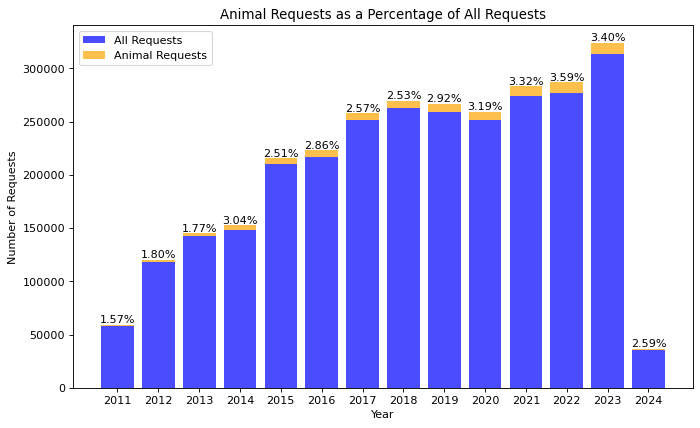

In [140]:
years = list(requests.keys())
all_values = [data['all'] for data in requests.values()]
animal_values = [data['animal'] for data in requests.values()]

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6), dpi=80)  # Set dpi to increase resolution
bars_all = plt.bar(years, all_values, label='All Requests', color='blue', alpha=0.7)
bars_animal = plt.bar(years, animal_values, bottom=all_values, label='Animal Requests', color='orange', alpha=0.7)

# Adding labels and a modified title
plt.xlabel('Year')
plt.ylabel('Number of Requests')
plt.title('Animal Requests as a Percentage of All Requests')
plt.legend()

# Adding text labels for the percentage (Animal Requests over All Requests)
for bar_all, bar_animal in zip(bars_all, bars_animal):
    height = bar_all.get_height() + bar_animal.get_height()
    percentage = (bar_animal.get_height() / height) * 100
    plt.text(bar_all.get_x() + bar_all.get_width() / 2, height, f'{percentage:.2f}%', ha='center', va='bottom')

# Show the plot
plt.show()

On the graph above, each bar represent the total request for a specific year. However, the bars contain two colors. Yellow corresponds to animal related requests while blue to every other request. The eprcentage on top of each bar represent the percentage of animal requests over all requests. We can definitely spot an increasing trend on requests, as well as on animal requests.

Let us now focus on animal requests.

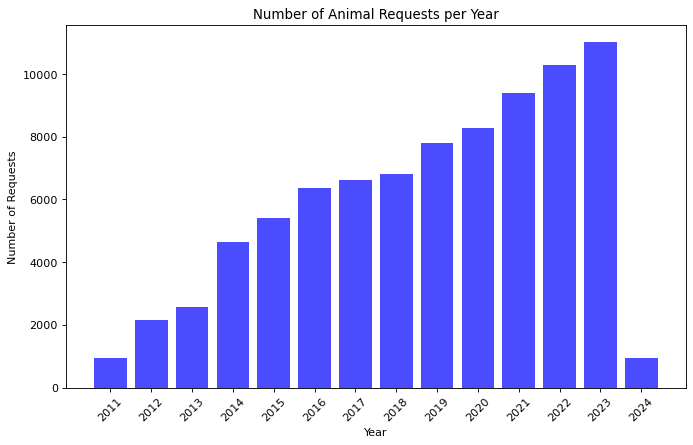

In [141]:
requests_per_year = df.groupby('year').size().reset_index(name='num_requests')

# Plotting the number of requests per year
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(requests_per_year['year'], requests_per_year['num_requests'], color='b', alpha=0.7)

# Adding labels, title, and rotating x-axis values
plt.xlabel('Year')
plt.ylabel('Number of Requests')
plt.title('Number of Animal Requests per Year')
plt.xticks(rotation=45)

plt.show()

The plot illustrates the annual count of animal requests, confirming the undeniable upward trend highlighted earlier.

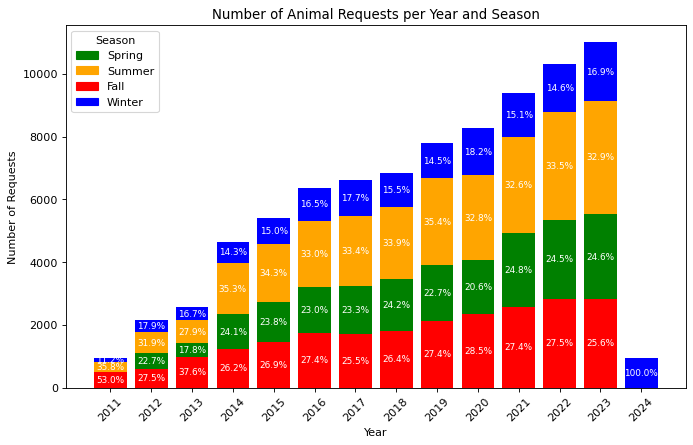

In [142]:
df['open_dt'] = pd.to_datetime(df['open_dt'])

# Map seasons to colors
seasonal_colors = {'Spring': 'green', 'Summer': 'orange', 'Fall': 'red', 'Winter': 'blue'}

# Extract year and season from 'open_dt'
df['year'] = df['open_dt'].dt.year
df['season'] = df['open_dt'].dt.month.map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                           5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                           9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'})

# Create a nested dictionary to store requests per year and season
requests_dict = defaultdict(dict)

# Populate the defaultdict with counts
for year, season, count in df.groupby(['year', 'season']).size().reset_index().values:
    requests_dict[year][season] = count

# Plotting the number of requests per year and season using the created dictionary
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)

legend_elements = [Patch(color=seasonal_colors[season], label=season) for season in seasonal_colors]

for year, season_requests in requests_dict.items():
    bottom = 0
    total_requests = sum(season_requests.values())
    for season, count in season_requests.items():
        percentage = count / total_requests * 100
        ax.bar(year, count, color=seasonal_colors[season], bottom=bottom)
        bottom += count

        # Adding percentage labels inside the bars
        ax.text(year, bottom - count / 2, f'{percentage:.1f}%', ha='center', va='center', color='white', fontsize=8)

# Adding labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Requests')
ax.set_title('Number of Animal Requests per Year and Season')

plt.xticks(list(requests_dict.keys()), rotation=45)

# Adding legend for seasons
ax.legend(handles=legend_elements, title='Season', loc='upper left')

# Show the plot
plt.show()

We sought to investigate the correlation between the volume of requests and the time of the year. As anticipated, the majority of requests are concentrated in the summer months. The accompanying percentages illustrate the distribution of requests across seasons.

Lastly, our exploration extended to identifying the various animals associated with these requests.

In [5]:
#read animal_cases.csv as df
df = pd.read_csv('data/animal_cases.csv')

/var/folders/qf/yh559xpx4dv12z0mkyw5cvr80000gn/T/ipykernel_7480/1890661383.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/animal_cases.csv')


To do this, we first need to manually check the format of "closure_reason". Employees give a closure status and then enter text indicating findings or work done to close a given case.

In [8]:
#print the number of rows that have "dog" in the "closure_reason" column
print(len(df[df['closure_reason'].str.contains('dog', case=False)]))
#print closure_reason of rows that have dog in closure_reason
list(df[df['closure_reason'].str.contains('dog', case=False)]['closure_reason'])[:10]

4801


['Case Closed Case Resolved  Sent a crew to the location and found nothing looked at the time it was called in on the night shift and they must of picked up the dog.  Russell Quigg  ',
 'Case Closed Case Resolved gm2 picked up dead dog ',
 'Case Closed Case Resolved  Dog is on PVT. property not on sidewalk I will send a crew back to pick up when the constituent removes the dog and puts it on the sidewalk.  Russell Quigg  ',
 'Case Closed Case Resolved gm2 picked up dead dog ',
 'Case Closed Case Noted Animal control took dog to marlowe st. Constituent can pick-up tomorrow. ',
 'Case Closed Case Resolved Dead animal removed (dog) ',
 'Case Closed Case Resolved there was no dead dog tobe found ',
 'Case Closed Case Resolved Dead dog removed by BPD  GM2 picked it up at So. Boston police station ',
 'Case Closed Case Resolved dist 1 picked up dead dog ',
 'Case Closed Case Resolved dog and cat were picked up. ']

Here is our initial methodology for extracting distinct animals from the "closure_reason" (we treat animals as nouns). Note that this dictionary that we create is expected to contain keys irrelevant to animals.

In [17]:
def extract_distinct_animals(sentence):
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    # Perform part-of-speech tagging to identify nouns (NN: singular noun, NNS: plural noun)
    pos_tags = pos_tag(words)

    # Extract nouns from the tagged words
    animals = [word for word, pos in pos_tags if pos in ['NN', 'NNS']]

    # Remove duplicates
    distinct_animals = list(set(animals))

    return distinct_animals
#use this function to extract distinct animals from the "closure_reason" column, put the result in a dict where keys are the animals and values are the number of occurrences
animal_counts = defaultdict(int)
for closure_reason in df['closure_reason']:
    animals = extract_distinct_animals(closure_reason)
    for animal in animals:
        animal_counts[animal] += 1


In our endeavor to streamline the identification of animal-related entities and minimize manual effort, we implemented a filtering mechanism. Specifically, we excluded keys (or nouns) appearing in fewer than three requests, as well as nouns with a length less than two and those containing special characters.

In [34]:
#remove all keys that have value of < 3
animal_counts = {key: value for key, value in animal_counts.items() if value > 3}
#remove all keys of less than 2 characters
animal_counts = {key: value for key, value in animal_counts.items() if len(key) > 2}
#remove all keys with dots, slashes, numbers and - in them
animal_counts = {key: value for key, value in animal_counts.items() if '.' not in key and '/' not in key and not any(char.isdigit() for char in key) and '-' not in key}

sorted_animal_counts = dict(sorted(animal_counts.items(), key=lambda item: item[1], reverse=True))
for animal, count in sorted_animal_counts.items():
    print(animal, count)

date 54291
EDT 11227
animal 7079
location 6428
EST 4555
dog 3531
rat 2799
shelter 2346
case 2242
set 2157
owner 2105
cat 1912
bird 1908
squirrel 1601
states 1471
property 1458
arrival 1355
caller 1170
information 1167
area 1132
contact 1083
request 1027
control 866
please 865
raccoon 838
constituent 827
Team 827
rabbit 805
error 796
dogs 786
call 723
officer 664
creation 650
nothing 647
rodent 625
complaint 616
street 600
hours 591
address 581
skunk 558
time 550
phone 496
days 437
responsibility 426
bat 425
picture 416
message 407
sidewalk 344
seagull 339
minutes 314
eform 313
notice 305
report 294
number 288
crew 281
service 262
possum 260
park 258
pigeon 242
scene 240
owners 240
wildlife 233
morning 231
reports 231
Case 228
goose 222
day 218
Tue 212
requests 210
Munroe 210
Thu 209
citation 207
inconvenience 206
pick 204
confusion 204
anything 197
bpw 182
roadway 174
door 167
inspection 160
animals 159
pickup 154
home 154
turkey 148
way 146
hawk 146
thank 144
file 142
dist 140
duplica

The aforementioned list was refined, and subsequently, we utilized the GPT-3.5 API to extract and concatenate the identified animals along with their respective frequencies of occurrence in the requests.

Please note that this particular segment has proven to be the most challenging, and we intend to refine our methods in the upcoming deliverable.

In [38]:
filtered_animals = {'Dog': 4317,
'Cat': 1996,
'Rat': 2857,
'Bird': 1983,
'Squirrel': 1631,
'Raccoon': 872,
'Rabbit': 817,
'Rodent': 655,
'Skunk': 558,
'Bat': 438,
'Possum': 260,
'Pigeon': 242,
'Goose': 222,
'Turkey': 169,
'Hawk': 146,
'Duck': 71,
'Deer': 45,
'Snake': 38,
'Turtle': 23,
'Swan': 23,
'Coyote': 91,
'Bunny': 78,
'Groundhog': 13,
'Beaver': 10,
'Chipmunk': 9,
'Chicken': 23,
'Dove': 20,
'Crow': 19,
'Owl': 19,
'Parakeet': 14,
'Robin': 12,
'Pig': 12,
'Sparrow': 8,
'Ferret': 8}

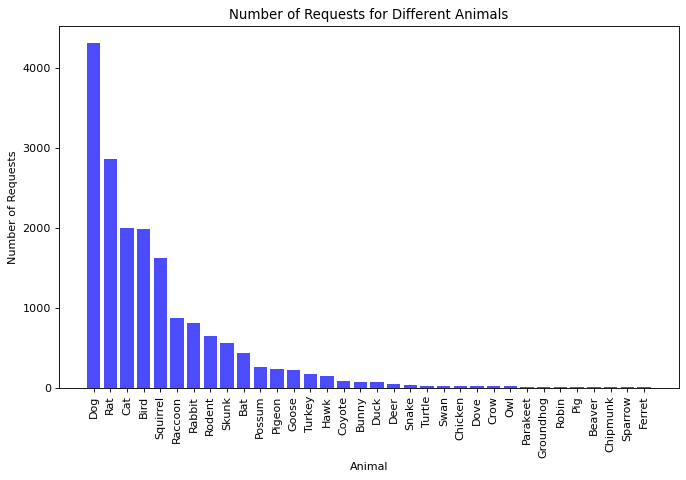

In [44]:
#sort the filtered_animals dictionary by value
filtered_animals = dict(sorted(filtered_animals.items(), key=lambda item: item[1], reverse=True))

#plot the filtered_animals dictionary as a bar chart
plt.figure(figsize=(10, 6), dpi=80)
plt.bar(filtered_animals.keys(), filtered_animals.values(), color='b', alpha=0.7)
plt.xlabel('Animal')
plt.ylabel('Number of Requests')
plt.title('Number of Requests for Different Animals')
plt.xticks(rotation=90)
plt.show()


Displayed above is the distribution of various animals within the requests. As anticipated, household pets such as dogs and cats dominate the list, along with common city-dwellers like rats, birds, and squirrels, reflective of our locale in Boston.